# Artigo 1
---

Escolhemos o artigo “Predicting At-Risk Students Using Clickstream Data in the Virtual Learning Environment” que usa o dataset OULAD (Open University Learning Analytics Dataset).
[Link para o dataset](https://analyse.kmi.open.ac.uk/open-dataset?utm_source).




## Reproduzindo os experimentos do artigo

### Imports necessários

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Lê os CSVs do dataset

Caso você adicione manualmente ou possui um path diferent do escrito abaixo, sinta-se livre
para alterar o drive_path. Caso esteja rodando localmente, recomento usar o `import os` para  usar o `Path` para ser independente de sistemas operacionais (Windows/UNIX-based).



In [ ]:
IS_LOCAL_CONTENT = False # Se colocarmos os arquivos em content, set para True
drive_path = '/content/'
if not IS_LOCAL_CONTENT:
  drive_path = '/content/drive/MyDrive/Período 3/ia/AV-I'

datasets = {
    'assessments': drive_path + '/assessments.csv',
    'courses': drive_path + '/courses.csv',
    'studentAssessment': drive_path + '/studentAssessment.csv',
    'studentInfo': drive_path + '/studentInfo.csv',
    'studentVle': drive_path + '/studentVle.csv',
    'vle': drive_path + '/vle.csv'
}


assessments = pd.read_csv(datasets['assessments'])
courses = pd.read_csv(datasets['courses'])
student_assessment = pd.read_csv(datasets['studentAssessment'])
student_info = pd.read_csv(datasets['studentInfo'])
student_vle = pd.read_csv(datasets['studentVle'])
vle = pd.read_csv(datasets['vle'])

In [ ]:
print("student info: ", student_info.shape)
print("student vle: ", student_vle.shape)
print("vle: ", vle.shape)



student info:  (32593, 12)
student vle:  (10655280, 6)
vle:  (6364, 6)


In [ ]:
student_info.head(10)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
6,AAA,2013J,45462,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass
7,AAA,2013J,45642,F,North Western Region,A Level or Equivalent,90-100%,0-35,0,120,N,Pass
8,AAA,2013J,52130,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass
9,AAA,2013J,53025,M,North Region,Post Graduate Qualification,NaN,55<=,0,60,N,Pass


In [ ]:
student_vle.head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8
6,AAA,2013J,28400,546876,-10,2
7,AAA,2013J,28400,546688,-10,15
8,AAA,2013J,28400,546662,-10,17
9,AAA,2013J,28400,546890,-10,1


In [ ]:
vle.head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
5,546614,AAA,2013J,homepage,NaN,NaN
6,546897,AAA,2013J,url,NaN,NaN
7,546678,AAA,2013J,oucontent,NaN,NaN
8,546933,AAA,2013J,resource,NaN,NaN
9,546708,AAA,2013J,oucontent,NaN,NaN


### Criando variável alvo binária

Assim como no artigo, vamos criar uma variável binária `final_binary` que irá possuir os valores 1 = Pass/Distinction, 0 = Fail.


In [ ]:
# Mudar Pass ou Fail para Boolean e retirar os Withdrawn
student_info = student_info[student_info['final_result'] != 'Withdrawn'].copy()
student_info['final_binary'] = student_info['final_result'].apply(lambda x: 0 if x == 'Fail' else 1)

### Agregando interações semanais por tipo de atividade

Produzimos uma estrutura (id_student, week, activity_type, sum_click).

In [ ]:
# Juntamos com tipos de atividades
vle_map = vle[['id_site', 'activity_type']].drop_duplicates()
student_vle = student_vle.merge(vle_map, on='id_site', how='left')

In [ ]:
# Converter as datas em semanas
student_vle['week'] = (student_vle['date'] // 7).astype(int) + 1 # Divisão de inteiros + 1 pra arredondar
student_vle.loc[student_vle['week'] > 38, 'week'] = 38 # Limit de 38 semanas

In [ ]:
# Agregar por estudantes / semana / tipo de atividade
agg = student_vle.groupby(['id_student', 'week', 'activity_type'])['sum_click'].sum().reset_index()
activity_types = sorted(agg['activity_type'].dropna().unique())

In [ ]:
# Agora vamos pivotar (linhas = estudante/semana, colunas = tipo de atividade)
pivot = agg.pivot_table(index=['id_student', 'week'], columns='activity_type', values='sum_click', fill_value=0)
pivot.reset_index(inplace=True)

In [ ]:
# Criar uma tablea completa (todas as semanas 1..38)
weeks = np.arange(1, 39) # 39, pois não é inclusivo
students = student_info['id_student'].unique()
rows = [(s, w) for s in students for w in weeks]
full_df = pd.DataFrame(rows, columns=['id_student', 'week'])
full_df = full_df.merge(pivot, on=['id_student', 'week'], how='left')
full_df[activity_types] = full_df[activity_types].fillna(0)

### Gerando o dataset cumulativo por semana

Teremos a soma de todos os cliques até a semana T (38 como dito no artigo).

In [ ]:
# Criar o dataset final
# Pega a soma cumulativa dos cliques até a semana T
# (para simular predição semana a semana)

def make_week_dataset(full_df, student_info, week):
  df_week = full_df[full_df['week'] <= week]
  agg_week = df_week.groupby('id_student')[activity_types].sum().reset_index()
  data = agg_week.merge(
      student_info[['id_student', 'final_binary']],
      on='id_student')
  X = data[activity_types].values
  y = data['final_binary'].values
  return X, y

In [ ]:
# modelos pra testar
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
}

In [ ]:
# Testar para semanas
# [5, 10, 20, 30, 38]

weeks_to_test = [5, 10, 20, 30, 38]
results = []

for week in weeks_to_test:
  print(f"\tSemana\t{week}")
  X, y = make_week_dataset(full_df, student_info, week)
  X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size=0.2,
      stratify=y,
      random_state=42)

  scaler = StandardScaler()
  X_train_s = scaler.fit_transform(X_train)
  X_test_s = scaler.transform(X_test)

  for name, model in models.items():
    model.fit(X_train_s, y_train)
    y_pred = model.predict(X_test_s)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{name}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")
    results.append({
        'week': week, 'model': name,
        'accuracy': acc, 'precision': prec,
        'reacall': rec, 'f1':f1
    })

	Semana	5
LogisticRegression: acc=0.6876, prec=0.6895, rec=0.9903, f1=0.8130
SVM: acc=0.6889, prec=0.6916, rec=0.9860, f1=0.8130
MLP: acc=0.7014, prec=0.7474, rec=0.8528, f1=0.7966
	Semana	10
LogisticRegression: acc=0.6943, prec=0.6934, rec=0.9932, f1=0.8167
SVM: acc=0.7322, prec=0.7413, rec=0.9360, f1=0.8273
MLP: acc=0.7302, prec=0.7570, rec=0.8931, f1=0.8194
	Semana	20
LogisticRegression: acc=0.7645, prec=0.7706, rec=0.9347, f1=0.8448
SVM: acc=0.7669, prec=0.7931, rec=0.8931, f1=0.8401


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: acc=0.7585, prec=0.7827, rec=0.8967, f1=0.8358
	Semana	30
LogisticRegression: acc=0.7883, prec=0.8144, rec=0.8954, f1=0.8529
SVM: acc=0.7984, prec=0.8190, rec=0.9061, f1=0.8604


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: acc=0.7921, prec=0.8142, rec=0.9028, f1=0.8562
	Semana	38
LogisticRegression: acc=0.8024, prec=0.8322, rec=0.8915, f1=0.8608
SVM: acc=0.8131, prec=0.8301, rec=0.9145, f1=0.8703
MLP: acc=0.8184, prec=0.8334, rec=0.9188, f1=0.8740


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Visualizando resultados

df_results = pd.DataFrame(results)
display(df_results)

,week,model,accuracy,precision,reacall,f1
0,5,LogisticRegression,0.687611,0.689523,0.990250,0.812967
1,5,SVM,0.688948,0.691589,0.986025,0.812969
2,5,MLP,0.701426,0.747365,0.852779,0.796600
3,10,LogisticRegression,0.694296,0.693442,0.993175,0.816676
4,10,SVM,0.732175,0.741313,0.935977,0.827348
5,10,MLP,0.730169,0.757025,0.893078,0.819442
6,20,LogisticRegression,0.764483,0.770632,0.934677,0.844764
7,20,SVM,0.766934,0.793074,0.893078,0.840110
8,20,MLP,0.758467,0.782695,0.896653,0.835807
9,30,LogisticRegression,0.788324,0.814366,0.895353,0.852941


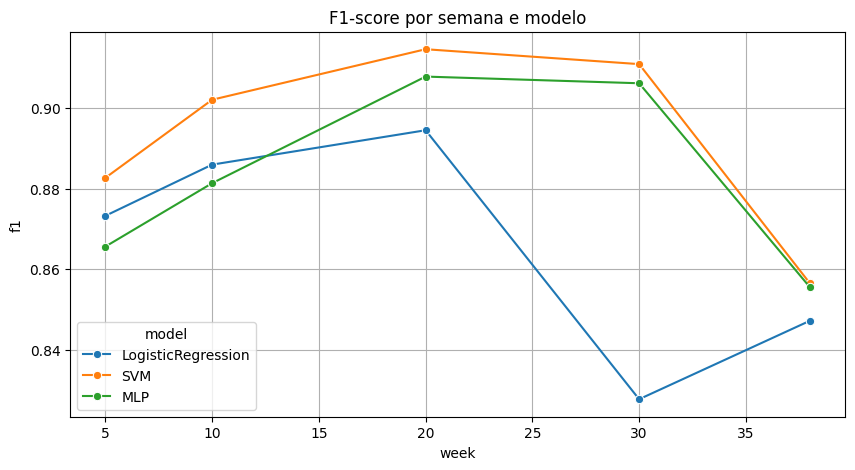

In [ ]:
# Gráfico comparando desempenho por semana
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x='week', y='f1', hue='model', marker='o')
plt.title("F1-score por semana e modelo")
plt.grid(True)
plt.show()


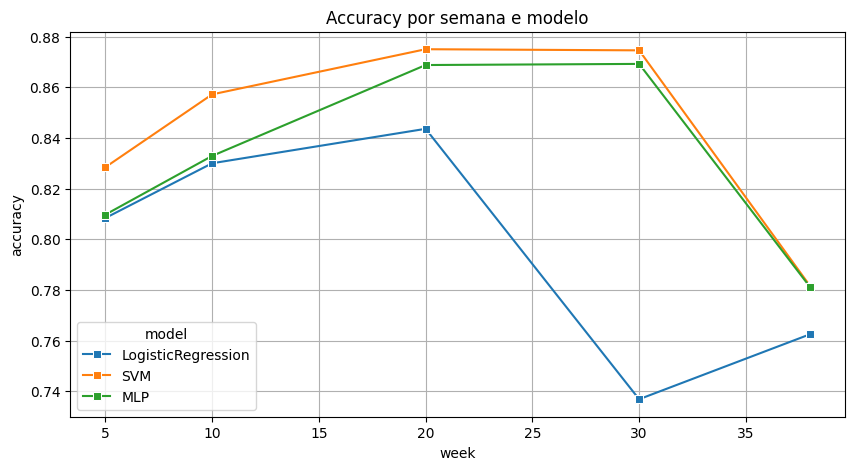

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x='week', y='accuracy', hue='model', marker='s')
plt.title("Accuracy por semana e modelo")
plt.grid(True)
plt.show()

## O que conseguimos reproduzir

O artigo “Predicting At-Risk Students Using Clickstream Data in the Virtual Learning Environment” (2023) usou o dataset OULAD e fez comparações entre métodos, ao longo de várias semanas de curso (5, 10, 20, 30, 38).


### O que conseguimos replicar as seguintes partes do experimento:

- Uso do dataset OULAD
  - Lê os mesmos arquivos CSV do Open University Learning Analytics Dataset
- Pré-processamento
  - Filtra estudantes, converte final_result → binário, agrega cliques por tipo de atividade e semana
- Janela temporal (5–38 semanas)
  - O código gera datasets até cada semana T, igual ao artigo
- Modelos clássicos (LR, SVM, MLP)
  - Reproduz os baselines descritos no artigo
- Métricas(accuracy, precision, recall, F1)
  - Calculadas da mesma forma
- Gráficos de desempenho por semana
  - As curvas de "Accuracy por semana" e "F1 score por semana" são equivalentes as do artigo
- A análise da evolução da performance com o tempo
  - Mostrar o mesmo padrão de aprendizado cumulativo

### O que não conseguimos replicar

- LSTSM sequencial
  - Não conseguimos fazer os modelos recorrentes com o `scikit-learn`, o artigo deve ter usado Keras ou TensorFlow.
- Entrada temporal (sequência por estudante)
  - Usamos clique até a semana T, já o artigo ele usa sequências como `[samples, timestamps, features]`
- Gráficos de perda (training vs validation loss)
  - Não conseguimos fornecer curva de perda epoch a epoch, e os outros modelos não têm isso.
- Comparação com dropout/early stopping
  - Necessário o uso de Keras
- Interpretação das features ao longo do tempo (saliency, feature importance)

## Melhorias

Ainda usando os modelos clássico (`LogisticRegression`, `SVM`, `MLP`), vamos adicionar uma **normalização temporal** (features semana a semana, padronizadas para cada estudante). Implementaresmos um **Grid Search** para econtrar hiperparâmetros ideais por semana. Enfim, calcularemos **Accuracy**, **Precision**, **Recall**, **F1** e mostraremos gráficos como os do artigo com (F1 e Accuracy x Semana).

### Imports necessários

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Lê os CSVs do dataset



In [ ]:
IS_LOCAL_CONTENT = False # Se colocarmos os arquivos em content, set para True
drive_path = '/content/'
if not IS_LOCAL_CONTENT:
  drive_path = '/content/drive/MyDrive/Período 3/ia/AV-I'

datasets = {
    'assessments': drive_path + '/assessments.csv',
    'courses': drive_path + '/courses.csv',
    'studentAssessment': drive_path + '/studentAssessment.csv',
    'studentInfo': drive_path + '/studentInfo.csv',
    'studentVle': drive_path + '/studentVle.csv',
    'vle': drive_path + '/vle.csv'
}


assessments = pd.read_csv(datasets['assessments'])
courses = pd.read_csv(datasets['courses'])
student_assessment = pd.read_csv(datasets['studentAssessment'])
student_info = pd.read_csv(datasets['studentInfo'])
student_vle = pd.read_csv(datasets['studentVle'])
vle = pd.read_csv(datasets['vle'])

### Criando variável alvo binária

Assim como no artigo, vamos criar uma variável binária `final_binary` que irá possuir os valores 1 = Pass/Distinction, 0 = Fail.


In [ ]:
# Mudar Pass ou Fail para Boolean e retirar os Withdrawn
student_info = student_info[student_info['final_result'] != 'Withdrawn'].copy()
student_info['final_binary'] = student_info['final_result'].apply(lambda x: 0 if x == 'Fail' else 1)

### Agregando interações semanais por tipo de atividade

Produzimos uma estrutura (id_student, week, activity_type, sum_click).

In [ ]:
# Juntamos com tipos de atividades
vle_map = vle[['id_site', 'activity_type']].drop_duplicates()
student_vle = student_vle.merge(vle_map, on='id_site', how='left')

In [ ]:
# Converter as datas em semanas
student_vle['week'] = (student_vle['date'] // 7).astype(int) + 1 # Divisão de inteiros + 1 pra arredondar
student_vle.loc[student_vle['week'] > 38, 'week'] = 38 # Limit de 38 semanas

In [ ]:
# Agregar por estudantes / semana / tipo de atividade
agg = student_vle.groupby(['id_student', 'week', 'activity_type'])['sum_click'].sum().reset_index()
activity_types = sorted(agg['activity_type'].dropna().unique())

In [ ]:
# Agora vamos pivotar (linhas = estudante/semana, colunas = tipo de atividade)
pivot = agg.pivot_table(index=['id_student', 'week'], columns='activity_type', values='sum_click', fill_value=0)
pivot.reset_index(inplace=True)

In [ ]:
# Criar uma tablea completa (todas as semanas 1..38)
weeks = np.arange(1, 39) # 39, pois não é inclusivo
students = student_info['id_student'].unique()
rows = [(s, w) for s in students for w in weeks]
full_df = pd.DataFrame(rows, columns=['id_student', 'week'])
full_df = full_df.merge(pivot, on=['id_student', 'week'], how='left')
full_df[activity_types] = full_df[activity_types].fillna(0)

### Normalização temporal

Vamos normalizar o padrão de cliques de cada estudante (dividindo pelos cliques totais dele)

In [ ]:
def normalize_temporal(df, feature_cols):
    df_norm = df.copy()
    totals = df_norm.groupby('id_student')[feature_cols].transform('sum') + 1e-6
    df_norm[feature_cols] = df_norm[feature_cols] / totals
    return df_norm

full_df = normalize_temporal(full_df, activity_types)

### Gerando o dataset cumulativo por semana

Construindo dataset até a semana T

In [ ]:
# Construir dataset até a semana T
def make_week_dataset(df, student_info, week):
    df_week = df[df['week'] <= week]
    agg_week = df_week.groupby('id_student')[activity_types].sum().reset_index()
    merged = agg_week.merge(student_info[['id_student','final_binary']], on='id_student')
    X = merged[activity_types].values
    y = merged['final_binary'].values
    return X, y

### Modelos + Grids de parâmetros

In [ ]:
grids = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=500, random_state=42),
        'params': {'C':[0.01,0.1,1,10], 'solver':['liblinear']}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C':[0.1,1,10], 'gamma':['scale','auto'], 'kernel':['rbf']}
    },
    'MLP': {
        'model': MLPClassifier(max_iter=500, random_state=42),
        'params': {
            'hidden_layer_sizes':[(100,50),(150,75),(200,100)],
            'alpha':[0.0001,0.001,0.01]
        }
    }
}

### Testando para semanas `[5,10,2030,38]`

In [ ]:
weeks_to_test = [5,10,20,30,38]
results = []

for week in weeks_to_test:
    print(f"\n========== Semana {week} ==========")
    X, y = make_week_dataset(full_df, student_info, week)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    for name, cfg in grids.items():
        gs = GridSearchCV(cfg['model'], cfg['params'], cv=3, scoring='f1', n_jobs=-1)
        gs.fit(X_train, y_train)
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append({
            'week': week, 'model': name,
            'accuracy': acc, 'precision': prec,
            'recall': rec, 'f1': f1,
            'best_params': gs.best_params_
        })
        print(f"{name} -> acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}, params={gs.best_params_}")



========== Semana 5 ==========
LogisticRegression -> acc=0.8084, prec=0.7990, rec=0.9626, f1=0.8732, params={'C': 0.01, 'solver': 'liblinear'}
SVM -> acc=0.8284, prec=0.8310, rec=0.9412, f1=0.8827, params={'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
MLP -> acc=0.8097, prec=0.8392, rec=0.8937, f1=0.8656, params={'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}

========== Semana 10 ==========
LogisticRegression -> acc=0.8300, prec=0.8203, rec=0.9630, f1=0.8859, params={'C': 0.01, 'solver': 'liblinear'}
SVM -> acc=0.8572, prec=0.8514, rec=0.9591, f1=0.9020, params={'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
MLP -> acc=0.8329, prec=0.8588, rec=0.9051, f1=0.8813, params={'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}

========== Semana 20 ==========
LogisticRegression -> acc=0.8436, prec=0.8322, rec=0.9669, f1=0.8945, params={'C': 0.01, 'solver': 'liblinear'}
SVM -> acc=0.8750, prec=0.8605, rec=0.9760, f1=0.9146, params={'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
MLP -> acc=0.8688, prec=0.

### Resultados

Resultados e Gráficos

In [ ]:
df_results = pd.DataFrame(results)
display(df_results)

,week,model,accuracy,precision,recall,f1,best_params
0,5,LogisticRegression,0.808378,0.799029,0.962626,0.873231,"{'C': 0.01, 'solver': 'liblinear'}"
1,5,SVM,0.828431,0.830990,0.941176,0.882658,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"
2,5,MLP,0.809715,0.839182,0.893728,0.865596,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}"
3,10,LogisticRegression,0.829991,0.820321,0.962951,0.885932,"{'C': 0.01, 'solver': 'liblinear'}"
4,10,SVM,0.857175,0.851414,0.959051,0.902033,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
5,10,MLP,0.832888,0.858773,0.905102,0.881329,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}"
6,20,LogisticRegression,0.843583,0.832168,0.966851,0.894468,"{'C': 0.01, 'solver': 'liblinear'}"
7,20,SVM,0.875000,0.860458,0.975951,0.914573,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}"
8,20,MLP,0.868761,0.875831,0.942151,0.907781,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}"
9,30,LogisticRegression,0.736854,0.750926,0.922002,0.827717,"{'C': 0.01, 'solver': 'liblinear'}"


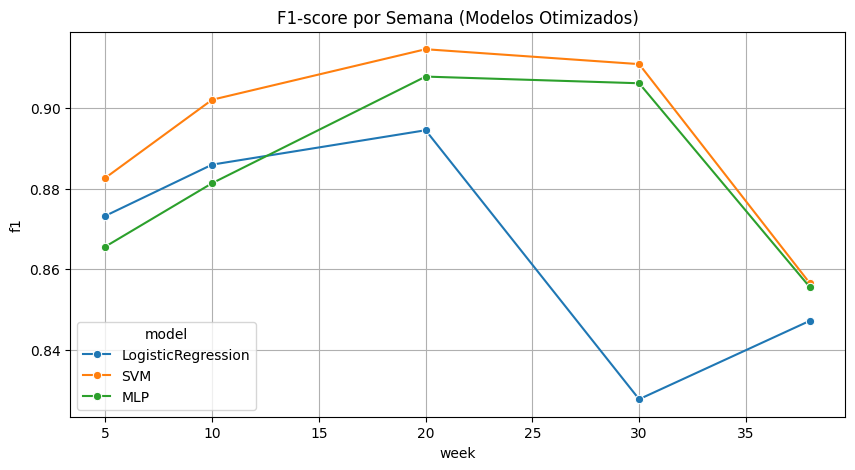

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x='week', y='f1', hue='model', marker='o')
plt.title("F1-score por Semana (Modelos Otimizados)")
plt.grid(True)
plt.show()

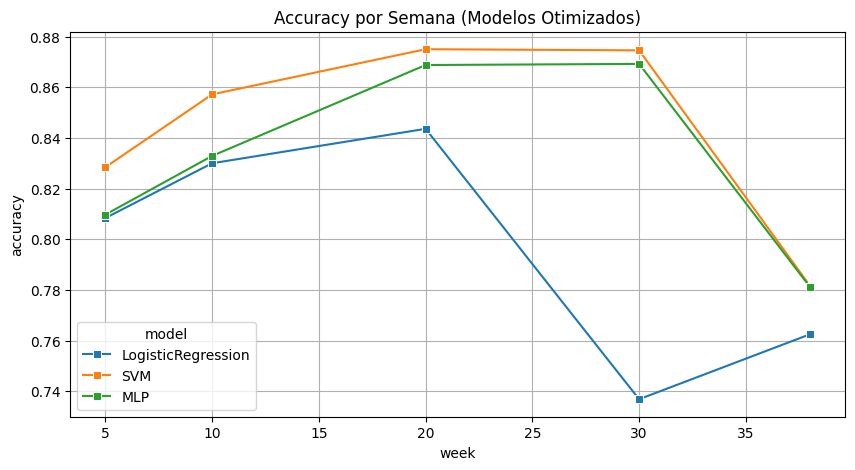

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x='week', y='accuracy', hue='model', marker='s')
plt.title("Accuracy por Semana (Modelos Otimizados)")
plt.grid(True)
plt.show()

## O que conseguimos com essas melhorias?

### Os resultados otimizados

O GridSearchCV faz busca em 3-fold cross-validation para cada modelo, selecionando hiperparâmetros que maximizam o F1-score.

### Normalização Temporal

Cada estudante tem seus cliques semanais normalizados pelo total acumulado, pois
isso evita que alunos com muitos acessos dominem o treinamento.
Essa etapa imita o masking/normalization aplicado implicitamente no LSTM do paper.